# Hungry Geese - Agents Comparison



- This notebook contains a lot of different agents from different sources for the [Hungry Geese](https://www.kaggle.com/c/hungry-geese).   
- In the [Comparison In Battle](#100) section, we also added a comparison of each pair of different agents (against two very simple additional agents so that real conditions are met). The agents fight for 100 rounds and then counts of the wins are calculated

# Quick Navigation

* [1. Simple Toward Agent](#1)
* [2. Greedy Agent](#2)
* [3. Risk Averse Greedy Agent](#3)
* [4. Simple BFS Agent](#4)
* [5. Straightforward BFS Agent](#5)
* [6. BoilerGoose Agent](#6)
* [7. Crazy Goose Agent](#7)
    

* [Example Using The kaggle_environments For Testing Agents](#50)
    
* [Comparison In Battle](#100)

<a id="1"></a>
## 1. Simple Toward Agent

In [4]:
%%writefile handcrafted_agents/simple_toward.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col


def agent(obs_dict, config_dict):
    """This agent always moves toward observation.food[0] but does not take advantage of board wrapping"""
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)
    food = observation.food[0]
    food_row, food_column = row_col(food, configuration.columns)

    if food_row > player_row:
        return Action.SOUTH.name
    if food_row < player_row:
        return Action.NORTH.name
    if food_column > player_column:
        return Action.EAST.name
    return Action.WEST.name

Writing handcrafted_agents/simple_toward.py


<a id="2"></a>
## 2. Greedy Agent

In [14]:
%%writefile handcrafted_agents/greedy.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
from random import choice, sample

def random_agent():
    return choice([action for action in Action]).name


def translate(position: int, direction: Action, columns: int, rows: int):
    row, column = row_col(position, columns)
    row_offset, column_offset = direction.to_row_col()
    row = (row + row_offset) % rows
    column = (column + column_offset) % columns
    return row * columns + column


def adjacent_positions(position: int, columns: int, rows: int):
    return [
        translate(position, action, columns, rows)
        for action in Action
    ]


def min_distance(position: int, food: [int], columns: int):
    row, column = row_col(position, columns)
    return min(
        abs(row - food_row) + abs(column - food_column)
        for food_position in food
        for food_row, food_column in [row_col(food_position, columns)]
    )


def agent(observation, configuration):
    observation = Observation(observation)
    configuration = Configuration(configuration)
    rows, columns = configuration.rows, configuration.columns

    food = observation.food
    geese = observation.geese
    opponents = [
        goose
        for index, goose in enumerate(geese)
        if index != observation.index and len(goose) > 0
    ]

    # Don't move adjacent to any heads
    head_adjacent_positions = {
        opponent_head_adjacent
        for opponent in opponents
        for opponent_head in [opponent[0]]
        for opponent_head_adjacent in adjacent_positions(opponent_head, rows, columns)
    }
    # Don't move into any bodies
    bodies = {position for goose in geese for position in goose[0:-1]}
    # Don't move into tails of heads that are adjacent to food
    tails = {
        opponent[-1]
        for opponent in opponents
        for opponent_head in [opponent[0]]
        if any(
            adjacent_position in food
            # Head of opponent is adjacent to food so tail is not safe
            for adjacent_position in adjacent_positions(opponent_head, rows, columns)
        )
    }

    # Move to the closest food
    position = geese[observation.index][0]
    actions = {
        action: min_distance(new_position, food, columns)
        for action in Action
        for new_position in [translate(position, action, columns, rows)]
        if (
            new_position not in head_adjacent_positions and
            new_position not in bodies and
            new_position not in tails
        )
    }

    if any(actions):
        return min(actions, key=actions.get).name

    return random_agent()

Writing handcrafted_agents/greedy.py


<a id="3"></a>
## 3. Risk Averse Greedy Agent

Copy from kernel [Risk averse greedy goose](https://www.kaggle.com/ilialar/risk-averse-greedy-goose)

In [6]:
%%writefile handcrafted_agents/risk_averse_greedy.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
import numpy as np
import random

def get_nearest_cells(x,y):
    # returns all cells reachable from the current one
    result = []
    for i in (-1,+1):
        result.append(((x+i+7)%7, y))
        result.append((x, (y+i+11)%11))
    return result

def find_closest_food(table):
    # returns the first step toward the closest food item
    new_table = table.copy()
    
    
    # (direction of the step, axis, code)
    possible_moves = [
        (1, 0, 1),
        (-1, 0, 2),
        (1, 1, 3),
        (-1, 1, 4)
    ]
    
    # shuffle possible options to add variability
    random.shuffle(possible_moves)
    
    
    updated = False
    for roll, axis, code in possible_moves:

        shifted_table = np.roll(table, roll, axis)
        
        if (table == -2).any() and (shifted_table[table == -2] == -3).any(): # we have found some food at the first step
            return code
        else:
            mask = np.logical_and(new_table == 0,shifted_table == -3)
            if mask.sum() > 0:
                updated = True
            new_table += code * mask
        if (table == -2).any() and shifted_table[table == -2][0] > 0: # we have found some food
            return shifted_table[table == -2][0]
        
        # else - update new reachible cells
        mask = np.logical_and(new_table == 0,shifted_table > 0)
        if mask.sum() > 0:
            updated = True
        new_table += shifted_table * mask

    # if we updated anything - continue reccurison
    if updated:
        return find_closest_food(new_table)
    # if not - return some step
    else:
        return table.max()

last_step = None

def agent(obs_dict, config_dict):
    global last_step
    
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)


    table = np.zeros((7,11))
    # 0 - emply cells
    # -1 - obstacles
    # -4 - possible obstacles
    # -2 - food
    # -3 - head
    # 1,2,3,4 - reachable on the current step cell, number is the id of the first step direction
    
    legend = {
        1: 'SOUTH',
        2: 'NORTH',
        3: 'EAST',
        4: 'WEST'
    }
    
    # let's add food to the map
    for food in observation.food:
        x,y = row_col(food, configuration.columns)
        table[x,y] = -2 # food
        
    # let's add all cells that are forbidden
    for i in range(4):
        opp_goose = observation.geese[i]
        if len(opp_goose) == 0:
            continue
            
        is_close_to_food = False
            
        if i != player_index:
            x,y = row_col(opp_goose[0], configuration.columns)
            possible_moves = get_nearest_cells(x,y) # head can move anywhere
            
            for x,y in possible_moves:
                if table[x,y] == -2:
                    is_close_to_food = True
            
                table[x,y] = -4 # possibly forbidden cells
        
        # usually we ignore the last tail cell but there are exceptions
        tail_change = -1
        if obs_dict['step'] % 40 == 39:
            tail_change -= 1
        
        # we assume that the goose will eat the food
        if is_close_to_food:
            tail_change += 1
        if tail_change >= 0:
            tail_change = None
            

        for n in opp_goose[:tail_change]:
            x,y = row_col(n, configuration.columns)
            table[x,y] = -1 # forbidden cells
    
    # going back is forbidden according to the new rules
    x,y = row_col(player_head, configuration.columns)
    if last_step is not None:
        if last_step == 1:
            table[(x + 6) % 7,y] = -1
        elif last_step == 2:
            table[(x + 8) % 7,y] = -1
        elif last_step == 3:
            table[x,(y + 10)%11] = -1
        elif last_step == 4:
            table[x,(y + 12)%11] = -1
        
    # add head position
    table[x,y] = -3
    
    # the first step toward the nearest food
    step = int(find_closest_food(table))
    
    # if there is not available steps try to go to possibly dangerous cell
    if step not in [1,2,3,4]:
        x,y = row_col(player_head, configuration.columns)
        if table[(x + 8) % 7,y] == -4:
            step = 1
        elif table[(x + 6) % 7,y] == -4:
            step = 2
        elif table[x,(y + 12)%11] == -4:
            step = 3
        elif table[x,(y + 10)%11] == -4:
            step = 4
                
    # else - do a random step and lose
        else:
            step = np.random.randint(4) + 1
    
    last_step = step
    return legend[step]

Writing handcrafted_agents/risk_averse_greedy.py


<a id="4"></a>
## 4. Simple BFS Agent

Copy from kernel [Simple BFS- Starter Agent](https://www.kaggle.com/aatiffraz/simple-bfs-starter-agent)

In [7]:
%%writefile handcrafted_agents/simple_bfs.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
import random
import numpy as np

directions = {0:'EAST', 1:'NORTH', 2:'WEST', 3:'SOUTH', 'EAST':0, 'NORTH':1, 'WEST':2, 'SOUTH':3}


def move(loc, direction):
    """Move the whole snake in the given direction"""
    global directions
    direction = directions[direction]
    new_loc = []
    if direction == 'EAST':
        new_loc.append(int(11*(loc[0]//11)  + (loc[0]%11 + 1)%11))
    elif direction == 'WEST':
        new_loc.append(int(11*(loc[0]//11) + (loc[0]%11 + 10)%11))
    elif direction == 'NORTH':
        new_loc.append(int(11*((loc[0]//11 + 6)%7) + loc[0]%11))
    else:
        new_loc.append(int(11*((loc[0]//11 + 1)%7) + loc[0]%11))
    if len(loc) == 1:
        return new_loc
    return new_loc + loc[:-1]
    

def greedy_choose(head, board):
    move_queue = []
    visited = [[[100, 'NA'] for _ in range(11)] for l in range(7)]
    visited[head//11][head%11][0] = 0
    
    for i in range(4):
        move_queue.append([head, [i]])
    
    while len(move_queue) > 0:
        now_move = move_queue.pop(0)
        
        next_step = move([now_move[0]], now_move[1][-1])[0]
        
        if board[next_step//11][next_step%11] < 0:
            continue
        
        if len(now_move[1]) < visited[next_step//11][next_step%11][0]:
            visited[next_step//11][next_step%11][0] = len(now_move[1])
            visited[next_step//11][next_step%11][1] = now_move[1][0]
            for i in range(4):
                move_queue.append([next_step, now_move[1] + [i]])
        
        if board[next_step//11][next_step%11] > 0:
            return now_move[1][0]
    return random.randint(0,3)
    
    
    
def agent(obs, conf):
    global directions

    obs = Observation(obs)
    conf = Configuration(conf)
    board = np.zeros((7, 11), dtype=int)
    
    #Obstacle-ize your opponents
    for ind, goose in enumerate(obs.geese):
        if ind == obs.index or len(goose) == 0:
            continue
        for direction in range(4):
            moved = move(goose, direction)
            for part in moved:
                board[part//11][part%11] -= 1
    
    #Obstacle-ize your body, except the last part
    if len(obs.geese[obs.index]) > 1:
        for k in obs.geese[obs.index][:-1]:
            board[k//11][k%11] -= 1
            
    #Count food only if there's no chance an opponent will meet you there
    for f in obs.food: 
        board[f//11][f%11] += (board[f//11][f%11] == 0)
        
    return directions[greedy_choose(obs.geese[obs.index][0], board)]


Writing handcrafted_agents/simple_bfs.py


<a id="5"></a>
## 5. Straightforward BFS Agent

In [8]:
%%writefile handcrafted_agents/straightforward_bfs.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
import numpy as np



def bfs(start_x, start_y, mask, food_coords):
    dist_matrix = np.zeros_like(mask)
    vect_matrix = np.full_like(mask, -1)
    
    queue = [(start_x, start_y, 0, None)]
    
    while queue:
        current_x, current_y, current_dist, vect = queue.pop(0)
        vect_matrix[current_x, current_y] = vect
        up_x = current_x + 1 if current_x != 6 else 0
        down_x = current_x - 1 if current_x != 0 else 6
        left_y = current_y - 1 if current_y != 0 else 10
        right_y = current_y + 1 if current_y != 10 else 0
        
        if mask[up_x, current_y] != -1 and not dist_matrix[up_x, current_y]:
            dist_matrix[up_x, current_y] = current_dist + 1
            if vect is None:
                queue.append((up_x, current_y, current_dist + 1, 0))
            else:
                queue.append((up_x, current_y, current_dist + 1, vect))
        if mask[down_x, current_y] != -1 and not dist_matrix[down_x, current_y]:
            dist_matrix[down_x, current_y] = current_dist + 1
            if vect is None:
                queue.append((down_x, current_y, current_dist + 1, 1))
            else:
                queue.append((down_x, current_y, current_dist + 1, vect))
        if mask[current_x, left_y] != -1 and not dist_matrix[current_x, left_y]:
            dist_matrix[current_x, left_y] = current_dist + 1
            if vect is None:
                queue.append((current_x, left_y, current_dist + 1, 2))
            else:
                queue.append((current_x, left_y, current_dist + 1, vect))
        if mask[current_x, right_y] != -1 and not dist_matrix[current_x, right_y]:
            dist_matrix[current_x, right_y] = current_dist + 1
            if vect is None:
                queue.append((current_x, right_y, current_dist + 1, 3))
            else:
                queue.append((current_x, right_y, current_dist + 1, vect))
            
    min_food_id = -1
    min_food_dist = np.inf
    for id_, food in enumerate(food_coords):
        if dist_matrix[food[0], food[1]] != 0 and min_food_dist > dist_matrix[food[0], food[1]]:
            min_food_id = id_
            min_food_dist = dist_matrix[food[0], food[1]]
    
    if min_food_id == -1:
        x, y = -1, -1
        mn = 0 
        for i in range(dist_matrix.shape[0]):
            for j in range(dist_matrix.shape[1]):
                if dist_matrix[i, j] > mn:
                    x, y = i, j
                    mn = dist_matrix[i, j]
        return vect_matrix[x, y]
    
    food_x, food_y = food_coords[min_food_id]
    return vect_matrix[food_x, food_y]


LAST_ACTION = None


def straightforward_bfs(obs_dict, config_dict):
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    start_row, start_col = row_col(player_head, configuration.columns)

    mask = np.zeros((configuration.rows, configuration.columns))
    for current_id in range(4):
        current_goose = observation.geese[current_id]
        for block in current_goose:
            current_row, current_col = row_col(block, configuration.columns)
            mask[current_row, current_col] = -1
    
    food_coords = []
    
    for food_id in range(configuration.min_food):
        food = observation.food[food_id]
        current_row, current_col = row_col(food, configuration.columns)
        mask[current_row, current_col] = 2
        food_coords.append((current_row, current_col))
        

    last_action = bfs(start_row, start_col, mask, food_coords)
    
    global LAST_ACTION
    up_x = start_row + 1 if start_row != 6 else 0
    down_x = start_row - 1 if start_row != 0 else 6
    left_y = start_col - 1 if start_col != 0 else 10
    right_y = start_col + 1 if start_col != 10 else 0
    
    step = Action.NORTH.name
    if last_action == 0:
        step = Action.SOUTH.name
        if LAST_ACTION == Action.NORTH.name:
            if mask[down_x, start_col] != -1:
                step = Action.NORTH.name
            elif mask[start_row, left_y] != -1:
                step = Action.WEST.name
            elif mask[start_row, right_y] != -1:
                step = Action.EAST.name
    if last_action == 1:
        step = Action.NORTH.name
        if LAST_ACTION == Action.SOUTH.name:
            if mask[up_x, start_col] != -1:
                step = Action.SOUTH.name
            elif mask[start_row, left_y] != -1:
                step = Action.WEST.name
            elif mask[start_row, right_y] != -1:
                step = Action.EAST.name
    if last_action == 2:
        step = Action.WEST.name
        if LAST_ACTION == Action.EAST.name:
            if mask[up_x, start_col] != -1:
                step = Action.SOUTH.name
            elif mask[down_x, start_col] != -1:
                step = Action.NORTH.name
            elif mask[start_row, right_y] != -1:
                step = Action.EAST.name
    if last_action == 3:
        step = Action.EAST.name
        if LAST_ACTION == Action.WEST.name:
            if mask[up_x, start_col] != -1:
                step = Action.SOUTH.name
            elif mask[down_x, start_col] != -1:
                step = Action.NORTH.name
            elif mask[start_row, left_y] != -1:
                step = Action.WEST.name
    LAST_ACTION = step
    
    return step

Writing handcrafted_agents/straightforward_bfs.py


<a id="6"></a>
## 6. BoilerGoose Agent

Copy from kernel [Mighty BoilerGoose with Flood fill](https://www.kaggle.com/superant/mighty-boilergoose-with-flood-fill)

In [9]:
%%writefile handcrafted_agents/boilergoose.py


import dataclasses
from dataclasses import dataclass
from typing import List, NamedTuple, Set, Dict, Optional, Tuple, Callable
import numpy as np
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
from abc import ABC, abstractmethod
import sys
import traceback


trans_action_map: Dict[Tuple[int, int], Action] = {
    (-1, 0): Action.NORTH,
    (1, 0): Action.SOUTH,
    (0, 1): Action.EAST,
    (0, -1): Action.WEST,
}


class Pos(NamedTuple):
    x: int
    y: int

    def __repr__(self):
        return f"[{self.x}:{self.y}]"


@dataclass
class Goose:
    head: Pos = dataclasses.field(init=False)
    poses: List[Pos]

    def __post_init__(self):
        self.head = self.poses[0]

    def __repr__(self):
        return "Goose(" + "-".join(map(str, self.poses)) + ")"

    def __iter__(self):
        return iter(self.poses)

    def __len__(self):
        return len(self.poses)


def field_idx_to_pos(field_idx: int, *, num_cols: int, num_rows: int) -> Pos:
    x = field_idx // num_cols
    y = field_idx % num_cols

    if not (0 <= x < num_rows and 0 <= y < num_cols):
        raise ValueError("Illegal field_idx {field_idx} with x={x} and y={y}")

    return Pos(x, y)


class Geometry:
    def __init__(self, size_x, size_y):
        self.size_x = size_x
        self.size_y = size_y

    @property
    def shape(self) -> Tuple[int, int]:
        return (self.size_x, self.size_y)

    def prox(self, pos: Pos) -> Set[Pos]:
        return {
            self.translate(pos, direction)
            for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]
        }

    def translate(self, pos: Pos, diff: Tuple[int, int]) -> Pos:
        x, y = pos
        dx, dy = diff
        return Pos((x + dx) % self.size_x, (y + dy) % self.size_y)

    def trans_to(self, pos1: Pos, pos2: Pos) -> Tuple[int, int]:
        dx = pos2.x - pos1.x
        dy = pos2.y - pos1.y

        if dx <= self.size_x // 2:
            dx += self.size_x

        if dx > self.size_x // 2:
            dx -= self.size_x

        if dy <= self.size_y // 2:
            dy += self.size_y

        if dy > self.size_y // 2:
            dy -= self.size_y

        return (dx, dy)

    def action_to(self, pos1, pos2):
        diff = self.trans_to(pos1, pos2)

        result = trans_action_map.get(diff)

        if result is None:
            raise ValueError(f"Cannot step from {pos1} to {pos2}")

        return result

@dataclass
class State:
    food: Set[Pos]
    geese: Dict[int, Goose]
    index: int
    step: int
    geo: Geometry

    field: np.ndarray = dataclasses.field(init=False)
    my_goose: Goose = dataclasses.field(init=False)
    danger_poses: Set[Pos] = dataclasses.field(init=False)

    def __post_init__(self):
        self.field = np.full(fill_value=0, shape=self.geo.shape)
        for goose in self.geese.values():
            for pos in goose.poses[:-1]:  # not considering tail!
                self.field[pos.x, pos.y] = 1
                
            if self.geo.prox(goose.head) & self.food:
                tail = goose.poses[-1]
                self.field[tail.x, tail.y] = 1
                

        self.my_goose = self.geese[self.index]

        self.danger_poses = {
            pos
            for i, goose in self.geese.items()
            if i != self.index
            for pos in self.geo.prox(goose.head)
        }

    @classmethod
    def from_obs_conf(cls, obs, conf):
        num_cols = conf["columns"]
        num_rows = conf["rows"]
        step = obs["step"]
        index = obs["index"]

        geese = {
            idx: Goose(
                poses=[
                    field_idx_to_pos(idx, num_cols=num_cols, num_rows=num_rows)
                    for idx in goose_data
                ]
            )
            for idx, goose_data in enumerate(obs["geese"])
            if goose_data
        }

        food = {
            field_idx_to_pos(idx, num_cols=num_cols, num_rows=num_rows)
            for idx in obs["food"]
        }

        return cls(
            food=food,
            geese=geese,
            index=index,
            step=step,
            geo=Geometry(size_x=num_rows, size_y=num_cols),
        )

    def __repr__(self):
        return (
            f"State(step:{self.step}, index:{self.index}, Geese("
            + ",".join(f"{idx}:{len(goose.poses)}" for idx, goose in self.geese.items())
            + f"), food:{len(self.food)})"
        )

@dataclass
class FloodfillResult:
    field_dist: np.ndarray
    frontiers: List[List[Tuple[int, int]]]


def flood_fill(is_occupied: np.ndarray, seeds: List[Pos]) -> FloodfillResult:
    """
    Flood will start with distance 0 at seeds and only flow where is_occupied[x,y]==0
    """
    size_x, size_y = is_occupied.shape

    field_dist = np.full(fill_value=-1, shape=(size_x, size_y))

    frontier = [(s.x, s.y) for s in seeds]

    frontiers = [frontier]

    for seed in seeds:
        field_dist[seed] = 0

    dist = 1

    while frontier:
        new_frontier: List[Tuple[int, int]] = []
        for x, y in frontier:
            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                new_x = (x + dx) % size_x
                new_y = (y + dy) % size_y
                if is_occupied[new_x, new_y] == 0 and field_dist[new_x, new_y] == -1:
                    field_dist[new_x, new_y] = dist
                    new_frontier.append((new_x, new_y))
        frontier = new_frontier
        frontiers.append(frontier)
        dist += 1

    return FloodfillResult(field_dist=field_dist, frontiers=frontiers)


def get_dist(
    floodfill_result: FloodfillResult, test_func: Callable[[Tuple[int, int]], bool]
) -> Optional[int]:
    for dist, frontier in enumerate(floodfill_result.frontiers):
        for pos in frontier:
            if test_func(pos):
                return dist

    return None

class BaseAgent(ABC):
    def __init__(self):
        self.last_pos: Optional[Pos] = None

    def __call__(self, obs, conf):
        try:
            state = State.from_obs_conf(obs, conf)

            next_pos = self.step(state)

            action = state.geo.action_to(state.my_goose.head, next_pos)

            self.last_pos = state.my_goose.head

            return action.name
        except Exception as exc:
            traceback.print_exc(file=sys.stderr)
            raise

    @abstractmethod
    def step(self, state: State) -> Pos:
        """
        return: next position

        Implement this
        """
        pass

    def next_poses(self, state: State) -> Set[Pos]:
        head_next_poses = state.geo.prox(state.my_goose.head)

        result = {
            pos
            for pos in head_next_poses
            if pos != self.last_pos and state.field[pos] == 0
        }

        return result

from operator import itemgetter
import random

class FloodGoose(BaseAgent):
    def __init__(self, min_length=13):
        super().__init__()
        self.min_length = min_length
        
    def step(self, state):
        result = None
        
        if len(state.my_goose) < self.min_length:
            result = self.goto(state, lambda pos:pos in state.food)
        elif len(state.my_goose) >= 3:
            result = self.goto(state, lambda pos:pos==state.my_goose.poses[-1])
            
        if result is None:
            result = self.random_step(state)
            
        return result
    
    def goto(self, state, test_func):
        result = None
        
        pos_dists = {}
        for pos in self.next_poses(state):
            flood = flood_fill(state.field, [pos])
            dist = get_dist(flood, test_func)
            if dist is not None:
                pos_dists[pos] = dist

        if pos_dists:
            closest_pos, _ = min(pos_dists.items(), key=itemgetter(1))

            if closest_pos not in state.danger_poses:
                result = closest_pos
                
        return result
        
    
    def random_step(self, state):
        next_poses = self.next_poses(state) - state.danger_poses - state.food
        if not next_poses:
            next_poses = self.next_poses(state) - state.danger_poses

            if not next_poses:
                next_poses = self.next_poses(state)

                if not next_poses:
                    next_poses = state.geo.prox(state.my_goose.head)
                        
        result = random.choice(list(next_poses))
        
        return result
    

agent = FloodGoose(min_length=8)

def call_agent(obs, conf):
    return agent(obs, conf)

Writing handcrafted_agents/boilergoose.py


<a id="7"></a>
## 7. Crazy Goose Agent

Copy from kernel [Crazy Goose](https://www.kaggle.com/gabrielmilan/crazy-goose)

In [10]:
%%writefile handcrafted_agents/crazy_goose.py

# Base code for this from
# https://www.kaggle.com/ilialar/risk-averse-greedy-goose

import numpy as np
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col

# Moves constants
SOUTH = 1
NORTH = 2
EAST  = 3
WEST  = 4
REVERSE_MOVE = {
    None : None,
    SOUTH: NORTH,
    NORTH: SOUTH,
    EAST : WEST,
    WEST : EAST,
}
CIRCLE_MOVE = {
    None : None,
    SOUTH: WEST,
    NORTH: EAST,
    EAST : SOUTH,
    WEST : NORTH
}

# Board constants
MY_HEAD             =  2
FOOD_CELL           =  1
EMPTY               =  0
HEAD_POSSIBLE_CELL  = -1
BODY_CELL           = -2

# Store last move
last_move = None
last_eaten = 0
last_size = 1
step = 0

# Returns a list of possible destinations in order to reach `dest_cell`
def move_towards (head_cell, neck_cell, dest_cell, configuration):
    print ("--- Computing food movements...")
    destinations = []
    x_head, y_head = row_col(head_cell, configuration.columns)
    x_neck, y_neck = row_col(neck_cell, configuration.columns)
    x_dest, y_dest = row_col(dest_cell, configuration.columns)
    print ("-> Head at ({}, {})".format(x_head, y_head))
    print ("-> Neck at ({}, {})".format(x_neck, y_neck))
    print ("-> Dest at ({}, {})".format(x_dest, y_dest))
    dx = x_head - x_dest
    dy = y_head - y_dest
    if (dx >= 4):
        dx = 7 - dx
    elif (dx <= -4):
        dx += 7
    if (dy >= 6):
        dy = 11 - dy
    elif (dy <= -6):
        dy += 11
    print ("dx={}, dy={}".format(dx, dy))
    if (dx > 0):
        x_move = (x_head - 1 + 7) % 7
        y_move = y_head
        print ("Move ({}, {}), Neck ({}, {})".format(x_move, y_move, x_neck, y_neck))
        if not ((x_move == x_neck) and (y_move == y_neck)):
            destinations.append((x_move, y_move, NORTH))
    elif (dx < 0):
        x_move = (x_head + 1 + 7) % 7
        y_move = y_head
        print ("Move ({}, {}), Neck ({}, {})".format(x_move, y_move, x_neck, y_neck))
        if not ((x_move == x_neck) and (y_move == y_neck)):
            destinations.append((x_move, y_move, SOUTH))
    if (dy > 0):
        x_move = x_head
        y_move = (y_head - 1 + 11) % 11
        print ("Move ({}, {}), Neck ({}, {})".format(x_move, y_move, x_neck, y_neck))
        if not ((x_move == x_neck) and (y_move == y_neck)):
            destinations.append((x_move, y_move, WEST))
    elif (dy < 0):
        x_move = x_head
        y_move = (y_head + 1 + 11) % 11
        print ("Move ({}, {}), Neck ({}, {})".format(x_move, y_move, x_neck, y_neck))
        if not ((x_move == x_neck) and (y_move == y_neck)):
            destinations.append((x_move, y_move, EAST))
    return destinations

def get_all_movements(goose_head, configuration):
    x_head, y_head = row_col(goose_head, configuration.columns)
    movements = []
    movements.append(((x_head - 1 + 7) % 7, y_head, NORTH))
    movements.append(((x_head + 1 + 7) % 7, y_head, SOUTH))
    movements.append((x_head, (y_head - 1 + 11) % 11, WEST))
    movements.append((x_head, (y_head + 1 + 11) % 11, EAST))
    return movements
    
def get_nearest_cells(x, y):
    # Returns adjacent cells from the current one
    result = []
    for i in (-1,+1):
        result.append(((x+i+7)%7, y))
        result.append((x, (y+i+11)%11))
    return result

# Compute L1 distance between cells
def cell_distance (a, b, configuration):
    xa, ya = row_col(a, configuration.columns)
    xb, yb = row_col(b, configuration.columns)
    dx = abs(xa - xb)
    dy = abs(ya - yb)
    if (dx >= 4):
        dx = 7 - dx
    if (dy >= 6):
        dy = 11 - dy
    return dx + dy

# Tells if that particular cell forbids movement on the next step
def is_closed (movement, board):
    return all([board[x_adj, y_adj] for (x_adj, y_adj) in get_nearest_cells(movement[0], movement[1])])

def is_safe (movement, board):
    return board[movement[0], movement[1]] >= 0

def is_half_safe (movement, board):
    return board[movement[0], movement[1]] >= -1

def agent (obs_dict, config_dict):
    global last_move
    global last_eaten
    global last_size
    global step
    print ("==============================================")
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)

    if (len(player_goose) > last_size):
        last_size = len(player_goose)
        last_eaten = step
    step += 1
    
    moves = {
        1: 'SOUTH',
        2: 'NORTH',
        3: 'EAST',
        4: 'WEST'
    }

    board = np.zeros((7, 11))
    
    # Adding food to board
    for food in observation.food:
        x, y = row_col(food, configuration.columns)
        print ("Food cell on ({}, {})".format(x, y))
        board[x, y] = FOOD_CELL
        
    # Adding geese to the board
    for i in range(4):
        goose = observation.geese[i]
        # Skip if goose is dead
        if len(goose) == 0:
            continue
        # If it's an opponent
        if i != player_index:
            x, y = row_col(goose[0], configuration.columns)
            # Add possible head movements for it
            for px, py in get_nearest_cells(x, y):
                print ("Head possible cell on ({}, {})".format(px, py))
                # If one of these head movements may lead the goose
                # to eat, add tail as BODY_CELL, because it won't move.
                if board[px, py] == FOOD_CELL:
                    x_tail, y_tail = row_col(goose[-1], configuration.columns)
                    print ("Adding tail on ({}, {}) as the goose may eat".format(x_tail, y_tail))
                    board[x_tail, y_tail] = BODY_CELL
                board[px, py] = HEAD_POSSIBLE_CELL
        # Adds goose body without tail (tail is previously added only if goose may eat)
        for n in goose[:-1]:
            x, y = row_col(n, configuration.columns)
            print ("Body cell on ({}, {})".format(x, y))
            board[x, y] = BODY_CELL
    
    # Adding my head to the board
    x, y = row_col(player_head, configuration.columns)
    print ("My head is at ({}, {})".format(x, y))
    board[x, y] = MY_HEAD
    
    # Debug board
    print (board)
    
    # Iterate over food and geese in order to compute distances for each one
    food_race = {}
    for food in observation.food:
        food_race[food] = {}
        for i in range(4):
            goose = observation.geese[i]
            if len(goose) == 0:
                continue
            food_race[food][i] = cell_distance(goose[0], food, configuration)
    
    # The best food is the least coveted
    best_food = None
    best_distance = float('inf')
    best_closest_geese = float('inf')
    for food in food_race:
        print ("-> Food on {}".format(row_col(food, configuration.columns)))
        my_distance = food_race[food][player_index]
        print (" - My distance is {}".format(my_distance))
        closest_geese = 0
        for goose_id in food_race[food]:
            if goose_id == player_index:
                continue
            if food_race[food][goose_id] <= my_distance:
                closest_geese += 1
        print (" - There are {} closest geese".format(closest_geese))
        if (closest_geese < best_closest_geese):
            best_food = food
            best_distance = my_distance
            best_closest_geese = closest_geese
            print ("  * This food is better")
        elif (closest_geese == best_closest_geese) and (my_distance <= best_distance):
            best_food = food
            best_distance = my_distance
            best_closest_geese = closest_geese
            print ("  * This food is better")
            
    # Now that the best food has been found, check if the movement towards it is safe.
    # Computes every available move and then check for move priorities.
    if len(player_goose) > 1:
        food_movements = move_towards(player_head, player_goose[1], best_food, configuration)
    else:
        food_movements = move_towards(player_head, player_head, best_food, configuration)
    all_movements = get_all_movements(player_head, configuration)
    # Excluding last movement reverse
    food_movements = [move for move in food_movements if move[2] != REVERSE_MOVE[last_move]]
    all_movements  = [move for move in all_movements if move[2] != REVERSE_MOVE[last_move]]
    print ("-> Available food moves: {}".format(food_movements))
    print ("-> All moves: {}".format(all_movements))
    
    # Trying to reach goal size of 4
    if (len(player_goose) < 4):
        
        # 1. Food movements that are safe and not closed
        for food_movement in food_movements:
            print ("Food movement {}".format(food_movement))
            if is_safe (food_movement, board) and not is_closed(food_movement, board):
                print ("It's safe! Let's move {}!".format(moves[food_movement[2]]))
                last_move = food_movement[2]
                return moves[food_movement[2]] # Move here

        # 2. Any movement safe and not closed
        for movement in all_movements:
            print ("Movement {}".format(movement))
            if is_safe (movement, board) and not is_closed(movement, board):
                print ("It's safe! Let's move {}!".format(moves[movement[2]]))
                last_move = movement[2]
                return moves[movement[2]] # Move here

        # 3. Food movements half safe and not closed
        for food_movement in food_movements:
            if is_half_safe (food_movement, board) and not is_closed(food_movement, board):
                print ("Food movement {} is half safe, I'm going {}!".format(food_movement, moves[food_movement[2]]))
                last_move = food_movement[2]
                return moves[food_movement[2]] # Move here

        # 4. Any movement half safe and not closed
        for movement in all_movements:
            if is_half_safe (movement, board) and not is_closed(movement, board):
                print ("Movement {} is half safe, I'm going {}!".format(movement, moves[movement[2]]))
                last_move = movement[2]
                return moves[movement[2]] # Move here

        # 5. Food movements that are safe
        for food_movement in food_movements:
            print ("Food movement {}".format(food_movement))
            if is_safe (food_movement, board):
                print ("It's safe! Let's move {}!".format(moves[food_movement[2]]))
                last_move = food_movement[2]
                return moves[food_movement[2]] # Move here

        # 6. Any movement safe
        for movement in all_movements:
            print ("Movement {}".format(movement))
            if is_safe (movement, board):
                print ("It's safe! Let's move {}!".format(moves[movement[2]]))
                last_move = movement[2]
                return moves[movement[2]] # Move here

        # 7. Food movements half safe
        for food_movement in food_movements:
            if is_half_safe (food_movement, board):
                print ("Food movement {} is half safe, I'm going {}!".format(food_movement, moves[food_movement[2]]))
                last_move = food_movement[2]
                return moves[food_movement[2]] # Move here

        # 8. Any movement half safe
        for movement in all_movements:
            if is_half_safe (movement, board):
                print ("Movement {} is half safe, I'm going {}!".format(movement, moves[movement[2]]))
                last_move = movement[2]
                return moves[movement[2]] # Move here
    
    # Just trying to walk in circles
    else:
        
        # Delete food moves
        food_coordinates = []
        for food in food_race:
            x_food, y_food = row_col(food, configuration.columns)
            food_coordinates.append((x_food, y_food))
        available_moves = []
        for move in all_movements:
            for (x_food, y_food) in food_coordinates:
                if (move[0] != x_food) or (move[1] != y_food):
                    available_moves.append(move)
        
        # 1. Run in circles if you can
        circle_move = CIRCLE_MOVE[last_move]
        for move in available_moves:
            if (move[2] == circle_move) and (is_safe(move, board)) and not (is_closed(move, board)):
                last_move = move[2]
                return moves[move[2]]
        
        # 2. Any movement safe and not closed
        for movement in all_movements:
            print ("Movement {}".format(movement))
            if is_safe (movement, board) and not is_closed(movement, board):
                print ("It's safe! Let's move {}!".format(moves[movement[2]]))
                last_move = movement[2]
                return moves[movement[2]] # Move here

        # 3. Any movement half safe and not closed
        for movement in all_movements:
            if is_half_safe (movement, board) and not is_closed(movement, board):
                print ("Movement {} is half safe, I'm going {}!".format(movement, moves[movement[2]]))
                last_move = movement[2]
                return moves[movement[2]] # Move here
            
        # 4. Any movement safe
        for movement in all_movements:
            print ("Movement {}".format(movement))
            if is_safe (movement, board):
                print ("It's safe! Let's move {}!".format(moves[movement[2]]))
                last_move = movement[2]
                return moves[movement[2]] # Move here
            
        # 5. Any movement half safe
        for movement in all_movements:
            if is_half_safe (movement, board):
                print ("Movement {} is half safe, I'm going {}!".format(movement, moves[movement[2]]))
                last_move = movement[2]
                return moves[movement[2]] # Move here
            
    # Finally, if all moves are unsafe, randomly pick one
    rand_pick = np.random.randint(4) + 1
    last_move = rand_pick
    print ("Yeah whatever, I'm going {}".format(moves[rand_pick]))
    return moves[rand_pick]

Writing handcrafted_agents/crazy_goose.py


<a id="50"></a>
## Example Using The kaggle_environments For Testing Agents

In [1]:
import collections

import kaggle_environments
from kaggle_environments import evaluate, make, utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

print(f'kaggle_environments version: {kaggle_environments.__version__}')

Loading environment football failed: No module named 'gfootball'
kaggle_environments version: 1.7.11


In [2]:
env = make("hungry_geese")

In [11]:
env.steps[1]

[{'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 1,
   'geese': [[35], [37], [28], [61]],
   'food': [34, 39],
   'index': 0},
  'status': 'ACTIVE'},
 {'action': 'SOUTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'ACTIVE'},
 {'action': 'EAST',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'ACTIVE'},
 {'action': 'EAST',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'ACTIVE'}]

In [8]:
env.reset()
env.run(
    [
        "handcrafted_agents/straightforward_bfs.py", 
        "handcrafted_agents/greedy.py", 
        "handcrafted_agents/risk_averse_greedy.py", 
        "handcrafted_agents/simple_bfs.py",
    ],
)
env.render(mode="ipython", width=800, height=700)

<a id="100"></a>
## Comparison In Battle

In [16]:
list_names = [
    "handcrafted_agents/simple_toward", 
    "handcrafted_agents/greedy",
    "handcrafted_agents/risk_averse_greedy",
    "handcrafted_agents/simple_bfs",
    "handcrafted_agents/straightforward_bfs",
    "handcrafted_agents/boilergoose",
    "handcrafted_agents/crazy_goose",
]

list_agents = [agent_name + ".py" for agent_name in list_names]

In [17]:
def one_on_one_with_two_simple(agents):
    n_agents = len(agents)

    scores = np.zeros((n_agents, n_agents), dtype=np.int)
    
    print("Simulation of battles. It can take some time...")

    for ind_1 in range(n_agents):
        for ind_2 in range(ind_1 + 1, n_agents):
            print(
                f"LOG: {agents[ind_1]} vs {agents[ind_2]} vs 2 X simple_toward", 
                end="\r"
            )

            current_score = evaluate(
                "hungry_geese", 
                [
                    agents[ind_1], 
                    agents[ind_2], 
                    "simple_toward.py", 
                    "simple_toward.py",
                ],
                num_episodes=100,
            )

            episode_winners = np.argmax(current_score, axis=1)
            episode_winner_counts = collections.Counter(episode_winners)

            scores[ind_1, ind_2] = episode_winner_counts.get(0, 0)
            scores[ind_2, ind_1] = episode_winner_counts.get(1, 0)

        print()
    
    return scores

In [18]:
def one_against_three(agents):
    n_agents = len(agents)

    scores = np.zeros((n_agents, n_agents), dtype=np.int)
    
    print("Simulation of battles. It can take some time...")

    for ind_1 in range(n_agents):
        for ind_2 in range(n_agents):
            print(
                f"LOG: {agents[ind_1]} vs 3 X {agents[ind_2]}", 
                end="\r"
            )

            current_score = evaluate(
                "hungry_geese", 
                [
                    agents[ind_1], 
                    agents[ind_2], 
                    agents[ind_2], 
                    agents[ind_2], 
                ],
                num_episodes=100,
            )

            episode_winners = np.argmax(current_score, axis=1)
            episode_winner_counts = collections.Counter(episode_winners)

            scores[ind_1, ind_2] = episode_winner_counts.get(0, 0)

        print()
    
    return scores

In [19]:
def visualize_scores(scores, x_agents, y_agents, title):
    df_scores = pd.DataFrame(
        scores, 
        index=x_agents, 
        columns=y_agents,
    )


    plt.figure(figsize=(3, 3))
    sn.heatmap(
        df_scores, annot=True, cbar=False, 
        cmap='coolwarm', linewidths=1, 
        linecolor='black', fmt="d",
    )
    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.title(title, fontsize=18)
    
    plt.show()

In [20]:
scores = one_on_one_with_two_simple(list_agents)
visualize_scores(scores, list_names, list_names, "Number of wins: one on one with two simple")

Simulation of battles. It can take some time...


TypeError: '>' not supported between instances of 'NoneType' and 'int'

Simulation of battles. It can take some time...
LOG: simple_toward.py vs 3 X crazy_goose.py
LOG: greedy.py vs 3 X crazy_goose.py
LOG: risk_averse_greedy.py vs 3 X crazy_goose.py
LOG: simple_bfs.py vs 3 X crazy_goose.py
LOG: straightforward_bfs.py vs 3 X crazy_goose.py
LOG: boilergoose.py vs 3 X crazy_goose.py
LOG: crazy_goose.py vs 3 X crazy_goose.py


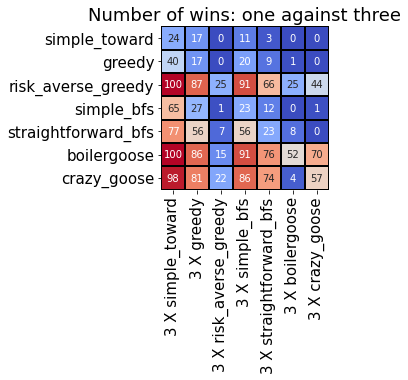

In [17]:
scores = one_against_three(list_agents)
visualize_scores(
    scores, 
    list_names, 
    list(map(lambda x: "3 X " + x, list_names)),
    "Number of wins: one against three"
)